4.892297203465946e-111


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,9,19,28,29,52,54,58,91,111) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


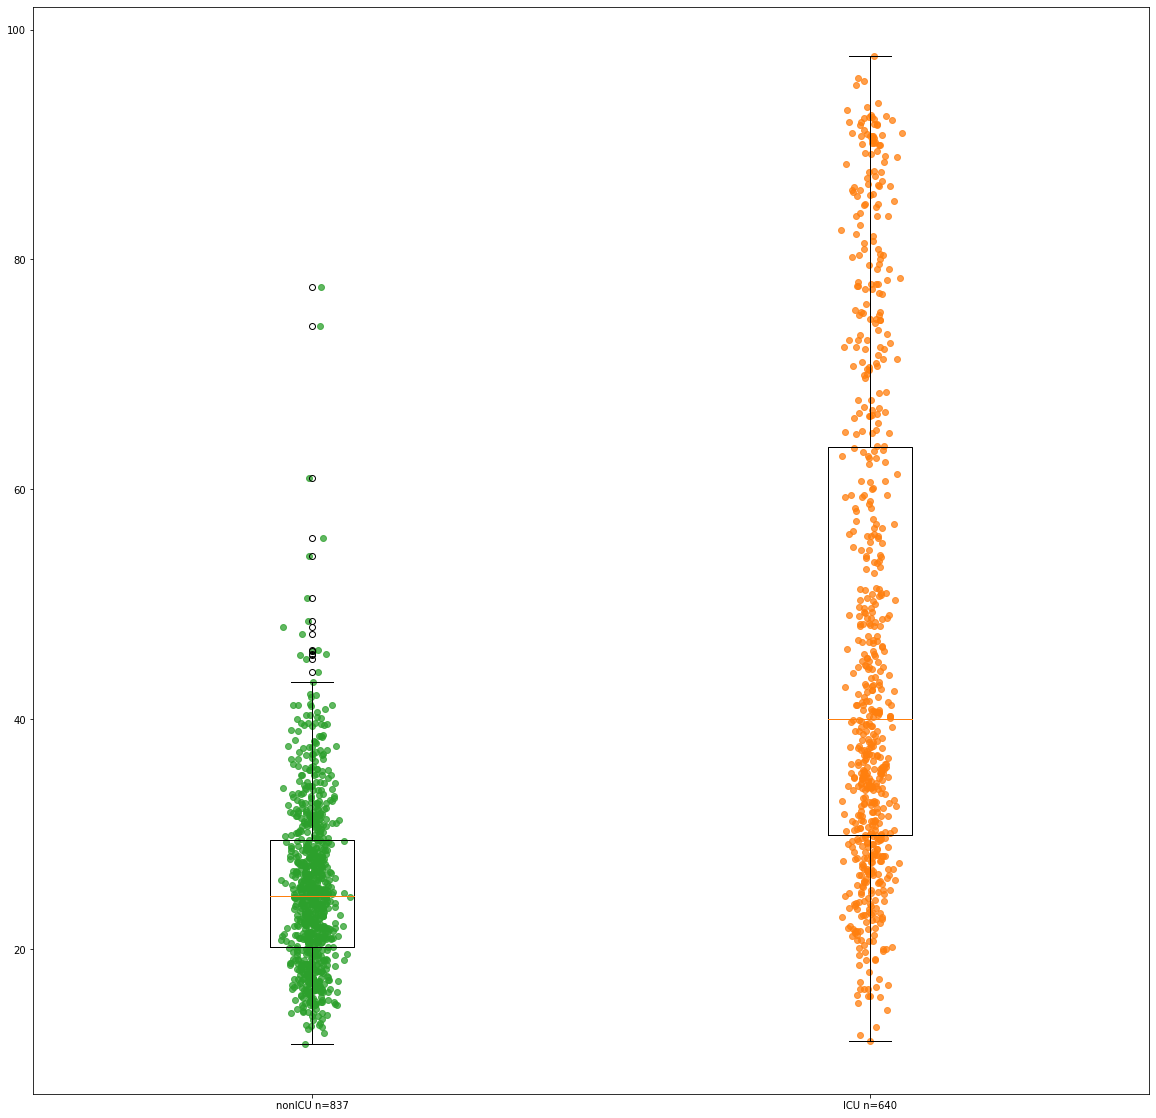

In [24]:
'''
script to visualize the deterioration index (DI) score in boxplots as well as create a clustermap using hierarchical clustering with ward linkage
'''

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
from scipy.stats import mannwhitneyu, wilcoxon
import itertools
from sklearn.preprocessing import StandardScaler
from numpy import inf
import math
from statsmodels.stats.multitest import multipletests
from matplotlib.pyplot import cm
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


df = pd.read_csv('/Users/tlh4362/Desktop/final_dataset_analysis_11_2.csv')
risk = pd.read_csv('/Users/tlh4362/Desktop/risk_scores.csv')

risk = pd.merge(risk, df.loc[:,['record_id', 'Clade', 'ICU','Number_of_vaccination_doses_before_infection']])
print(mannwhitneyu(risk[risk['ICU']==0]['median'].dropna(), risk[risk['ICU']==1]['median'].dropna()).pvalue)
plt.figure(figsize = [20,20])
plt.boxplot(risk[risk['ICU']==0]['median'].dropna(), positions = [0], labels = ['nonICU n={}'.format(risk[risk['ICU']==0]['median'].dropna().shape[0])])
jitters = np.random.normal(0 , 0.02, risk[(risk['ICU']==0)]['median'].dropna().shape[0])
plt.scatter(jitters, risk[(risk['ICU']==0)]['median'].dropna(), marker = 'o', alpha = 0.75, color = 'tab:green')

plt.boxplot(risk[risk['ICU']==1]['median'].dropna(), positions = [1], labels = ['ICU n={}'.format(risk[risk['ICU']==1]['median'].dropna().shape[0])])
jitters = np.random.normal(1 , 0.02, risk[(risk['ICU']==1)]['median'].dropna().shape[0])
plt.scatter(jitters, risk[(risk['ICU']==1)]['median'].dropna(), marker = 'o', alpha = 0.75, color = 'tab:orange')
# plt.savefig('/Users/tlh4362/Desktop/icuvnonicu_di.eps',format = 'eps', bbox_inches = 'tight')

<ipython-input-15-4cdeec48493f>:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrBr_r"))
  my_cmap.set_bad('white')
<ipython-input-15-4cdeec48493f>:22: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrBr_r"))
  my_cmap.set_over('lightgrey')


<AxesSubplot:>

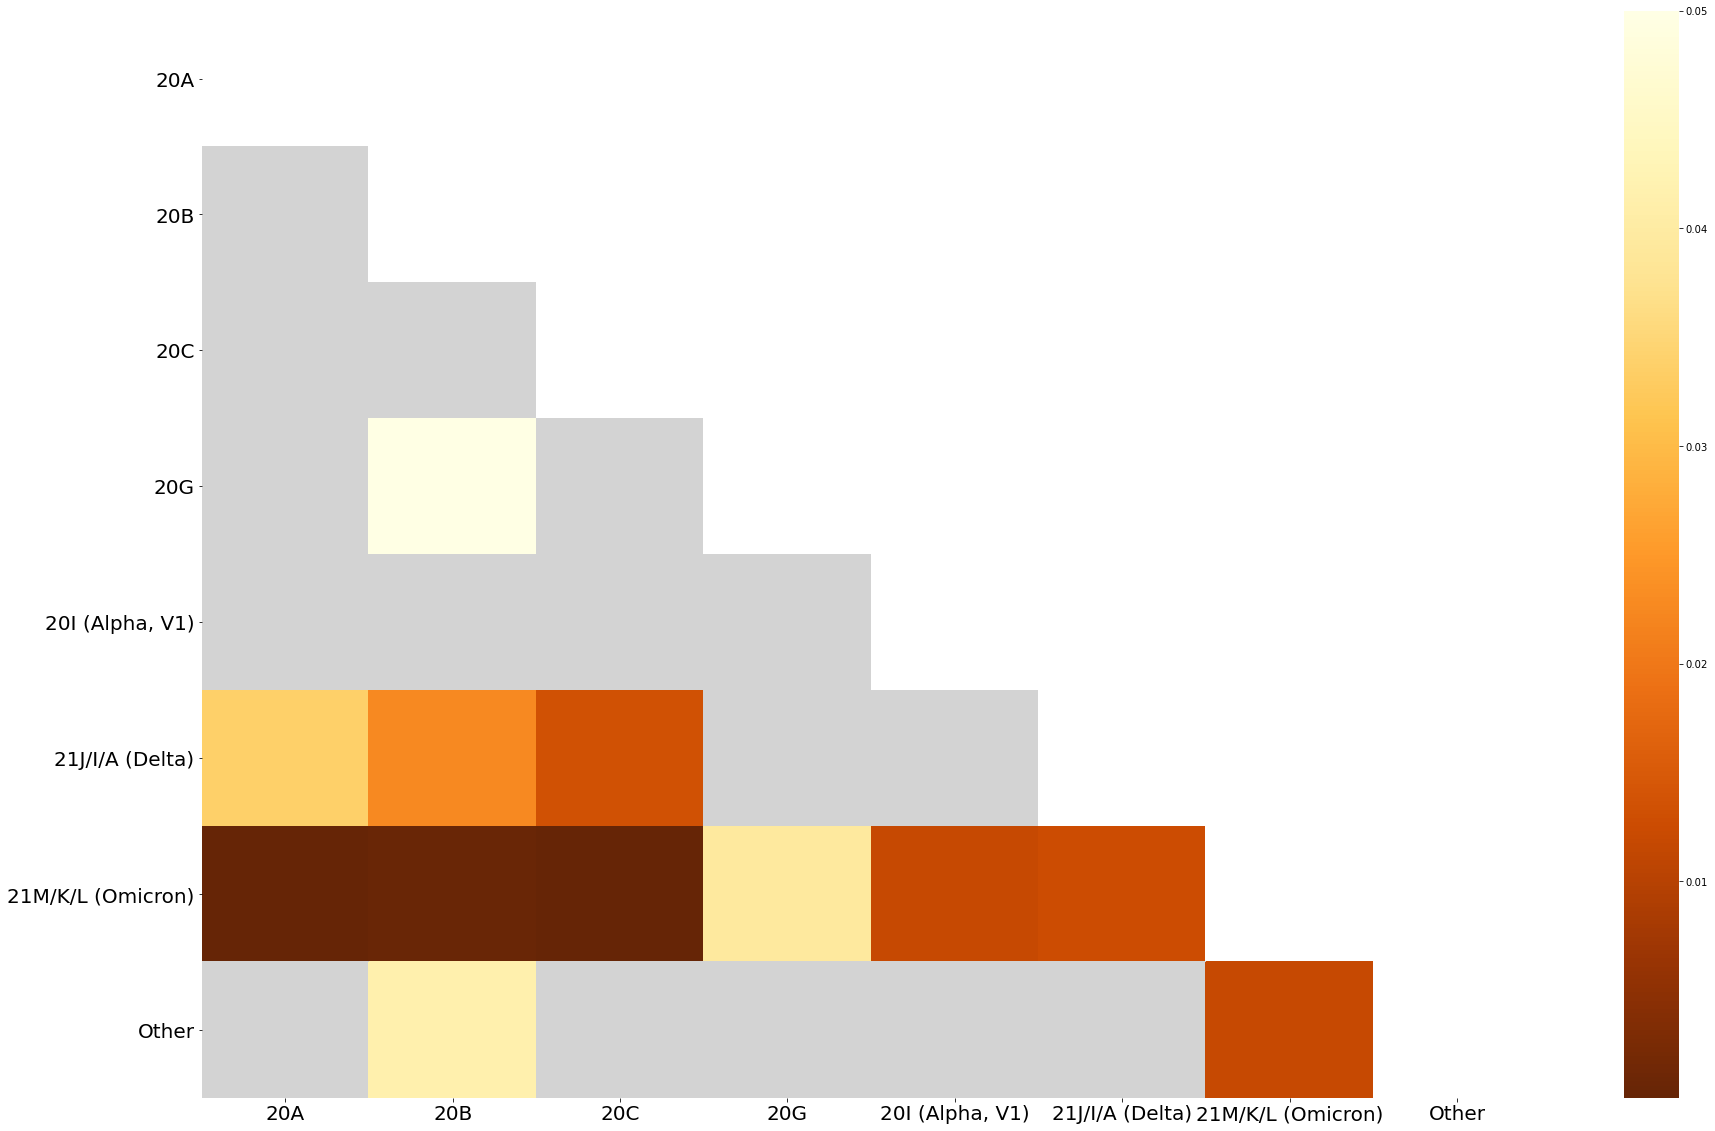

In [15]:
pvals = {}

for pair in itertools.combinations(['20A','20B', '20C',  '20G',   '20I (Alpha, V1)','21J/I/A (Delta)','21M/K/L (Omicron)', 'Other']
, 2):
    clade1 = risk[risk['Clade']==pair[0]]['median']
    clade2 = risk[risk['Clade']==pair[1]]['median']
    pvals[pair] = mannwhitneyu(clade1,clade2).pvalue
heatmap_df = pd.DataFrame()

for i in range(len(pvals.keys())):
    clade1 = list(pvals.keys())[i][0]
    clade2 = list(pvals.keys())[i][1]
    heatmap_df.at[clade1, clade2] = multipletests(list(pvals.values()), alpha = 0.05, method = 'fdr_bh')[1][i]
    heatmap_df.at[clade2, clade1] = multipletests(list(pvals.values()), alpha = 0.05, method = 'fdr_bh')[1][i]
heatmap_df = heatmap_df.loc[:,heatmap_df.index]

matrix = np.triu(heatmap_df)


my_cmap = sns.color_palette("YlOrBr_r", as_cmap=True)
my_cmap.set_bad('white')
my_cmap.set_over('lightgrey')
plt.figure(figsize = [30,20])
plt.tick_params(labelsize=20)

sns.heatmap(heatmap_df, mask = matrix, cmap = my_cmap, vmax = 0.05)

# plt.savefig('/Users/tlh4362/Desktop/discore_comparison.png')


(array([  0.,  20.,  40.,  60.,  80., 100.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

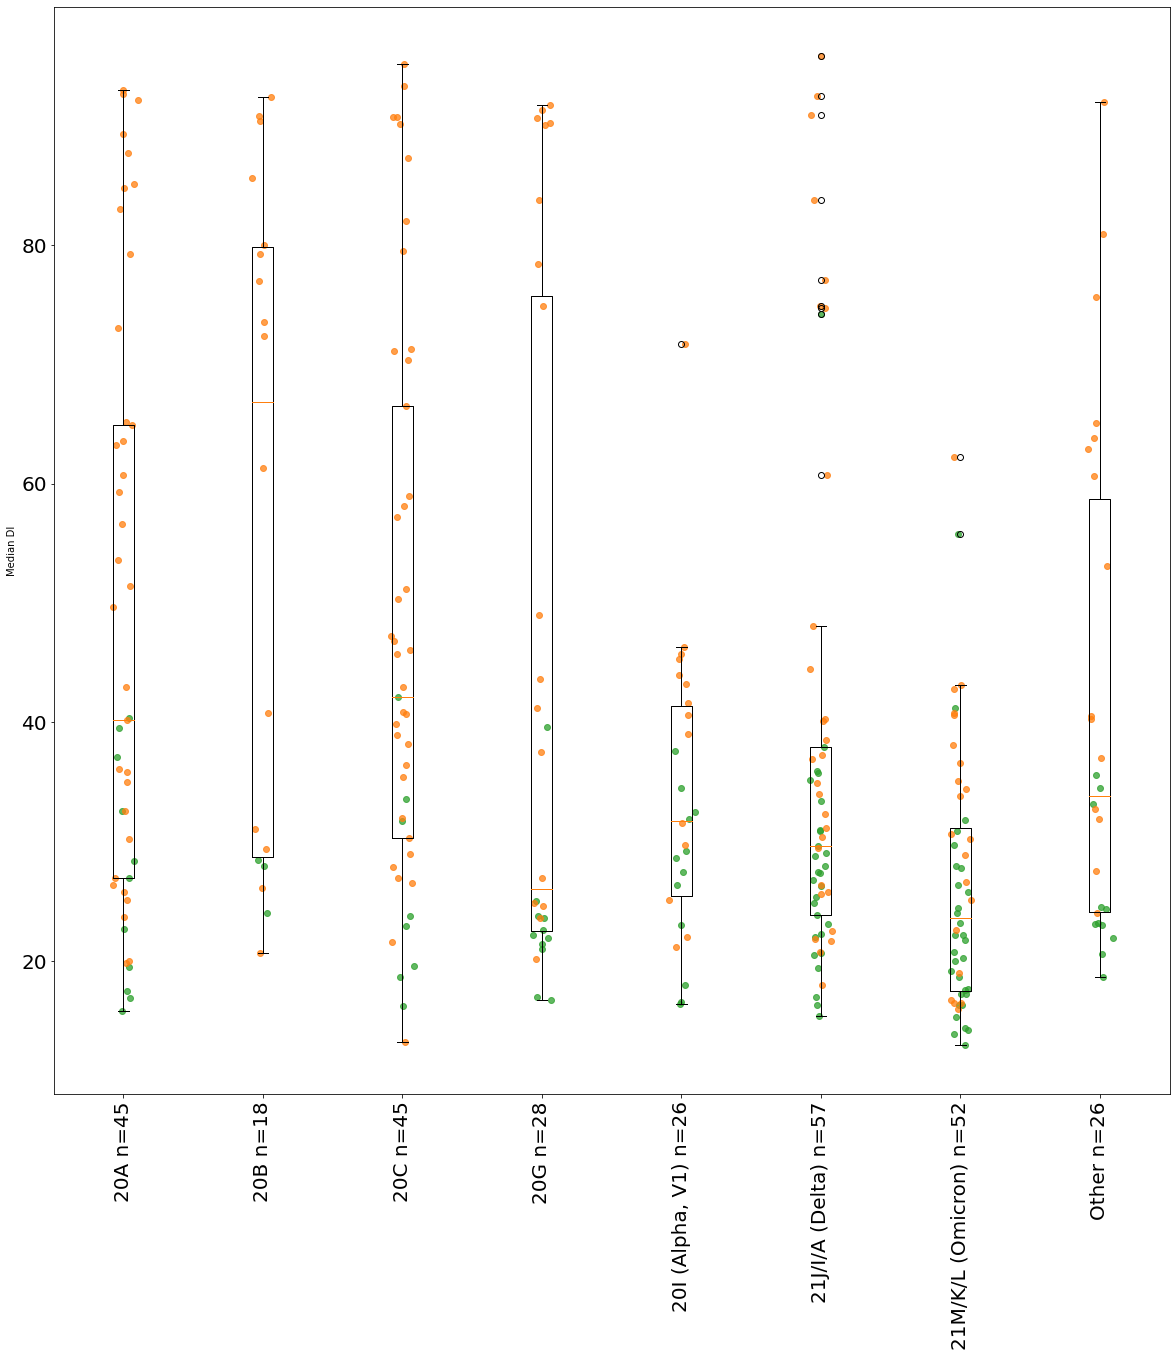

In [17]:
plt.figure(figsize = [20,20])

clades = ['20A','20B', '20C',  '20G',   '20I (Alpha, V1)','21J/I/A (Delta)','21M/K/L (Omicron)', 'Other']
for c in range(len(clades)):
    clade = clades[c]
    plt.boxplot(risk[risk['Clade']==clade]['median'].dropna(), labels =['{} n={}'.format(clade, risk[risk['Clade']==clade]['median'].dropna().shape[0])], positions = [c])
    color = cm.rainbow(np.linspace(0, 1, len(clades)))
    for icu in range(2):
        jitters = np.random.normal(c , 0.04, risk[(risk['Clade']==clade) & (risk['ICU']==icu)]['median'].dropna().shape[0])

        if icu == 0:
            plt.scatter(jitters, risk[(risk['Clade']==clade) & (risk['ICU']==icu)]['median'].dropna(), marker = 'o', alpha = 0.75, label = [clade], color = 'tab:green')
        else:
            plt.scatter(jitters, risk[(risk['Clade']==clade) & (risk['ICU']==icu)]['median'].dropna(), marker = 'o', alpha = 0.75, label = [clade], color = 'tab:orange')

plt.ylabel('Median DI')
plt.xticks(fontsize = 20, rotation = 90)
plt.yticks(fontsize = 20)

# plt.savefig('/Users/tlh4362/Desktop/fig5/fig5b.eps', format = 'eps', bbox_inches = 'tight')




/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

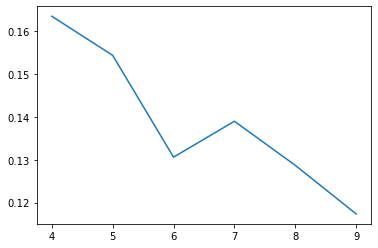

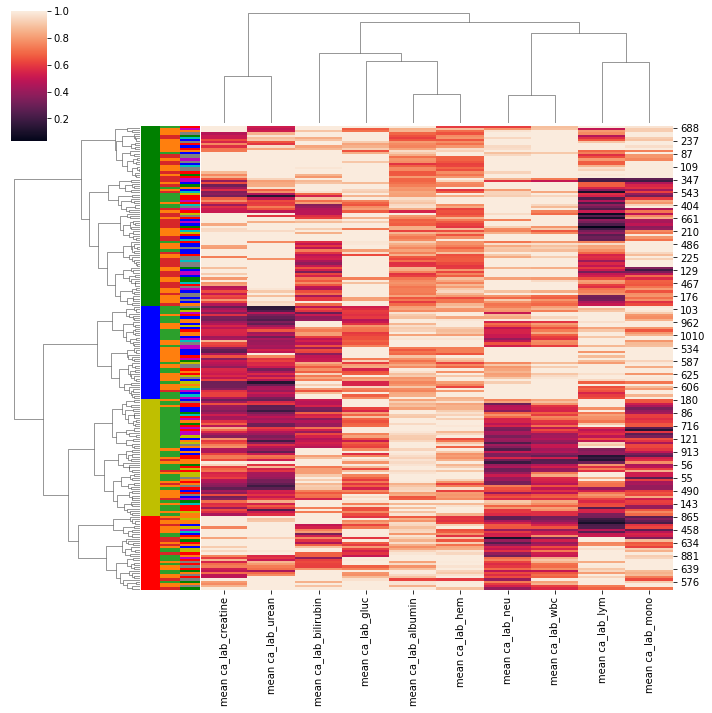

In [18]:
completelabs = df.loc[:, ['mean ca_lab_albumin', 'mean ca_lab_bilirubin',
       'mean ca_lab_creatine',
       'mean ca_lab_gluc', 'mean ca_lab_hem',
       'mean ca_lab_lym', 'mean ca_lab_mono', 'mean ca_lab_neu',
       'mean ca_lab_urean', 'mean ca_lab_wbc', 'record_id']].dropna()

for c in completelabs.columns:
    if c == 'record_id':
        next
    else:
        tmp = completelabs[c]
        upperbound = 0.75
#         lowerbound = 0.05
        
        idxupper = tmp[tmp>tmp.quantile(upperbound)].index
#         idxlower = tmp[tmp<tmp.quantile(lowerbound)].index
        if len(idxupper) == 0:
            next
#         elif len(idxupper) != 0 and len(idxlower) == 0:
#             tmp.loc[idxupper] = tmp.quantile(upperbound)

#         elif len(idxupper) == 0 and len(idxlower) != 0:
#             tmp.loc[idxlower] = tmp.quantile(lowerbound)
        else:
            tmp.loc[idxupper] = tmp.quantile(upperbound)
#             tmp.loc[idxlower] = tmp.quantile(lowerbound)

        completelabs[c] = tmp
        completelabs[c] = completelabs[c]/completelabs[c].max()
        
total_outcomes = []
completelabs = pd.merge(completelabs, df.loc[:,['record_id', 'Clade','ICU', 'ca_death']])

for idx in completelabs.index:
    if completelabs.loc[idx, 'ca_death'] == 1:
        total_outcomes.append('Death')
    elif completelabs.loc[idx, 'ca_death'] == 0 and completelabs.loc[idx,'ICU']==1:
        total_outcomes.append('ICU')
    elif completelabs.loc[idx, 'ca_death'] == 0 and completelabs.loc[idx,'ICU']==0:
        total_outcomes.append('nonICU')
    else:
        print(idx)
completelabs['total_outcomes'] = total_outcomes
completelabs = completelabs[completelabs['Clade'].notnull()]
c = []
s = []
for ncluster in range(4, 10):
    completelabs_norid = completelabs.drop(['Clade', 'record_id', 'ICU', 'ca_death','total_outcomes'], axis = 1)

    cluster = AgglomerativeClustering(n_clusters=ncluster, affinity='euclidean', linkage='ward')
    cluster.fit(completelabs_norid)

    clust_labs = pd.Series(cluster.fit_predict(completelabs_norid))
    
    s.append(silhouette_score(completelabs_norid, clust_labs))
    
plt.plot(range(4,10), s)

#by clade
clade = df[(df['record_id'].isin(completelabs['record_id'])) & (df['Clade'].notnull())]['Clade']
lutclade = dict(zip(clade.unique(), ['b', 'g', 'grey', 'c', 'm', 'y', 'r', 'tab:orange', 'k']))

row_colors1 = clade.map(lutclade)

# icu = df[(df['record_id'].isin(completelabs['record_id']))  & (df['Clade'].notnull())]['ICU']
luticu = dict(zip(completelabs['total_outcomes'].unique(), ['tab:orange', 'tab:green', 'tab:red']))

row_colors2 = completelabs['total_outcomes'].map(luticu)

completelabs_norid = completelabs.drop(['Clade', 'record_id', 'ICU', 'ca_death','total_outcomes'], axis = 1)


ncluster = 4
linkage = 'ward'

lutclust = dict(zip(list(range(ncluster)), 'rgbycmkw'))

cluster = AgglomerativeClustering(n_clusters=ncluster, affinity='euclidean', linkage=linkage)
clust_labs = pd.Series(cluster.fit_predict(completelabs_norid))
row_colors3 = clust_labs.map(lutclust)


hc = sns.clustermap(completelabs_norid, method = linkage, col_cluster = True, row_cluster = True,  row_colors = [ row_colors3, row_colors2, row_colors1])

# plt.savefig('/Users/tlh4362/Desktop/labs.eps', bbox_inches = 'tight', format = 'eps')


################
Clade
################


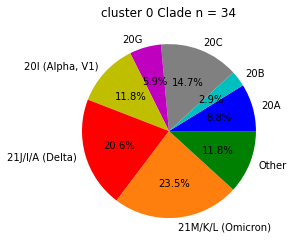

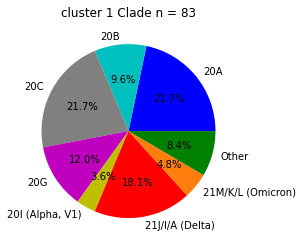

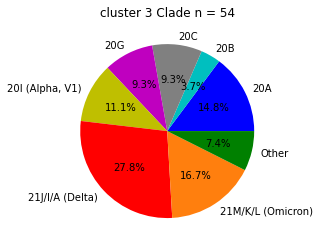

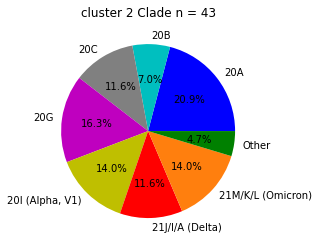

################
total_outcomes
################


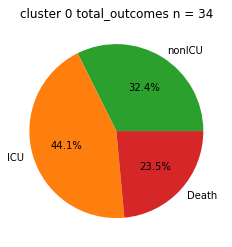

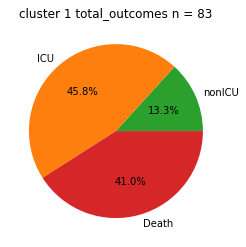

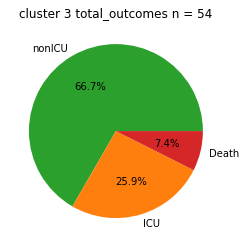

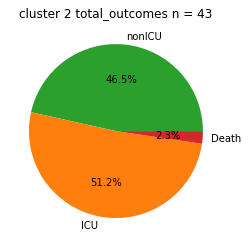

In [19]:
completelabs = completelabs.reset_index()
completelabs['clustlabs'] = clust_labs
for outcomes in ['Clade', 'total_outcomes']:
    print('################')
    print(outcomes)
    print('################')
    for clust in completelabs['clustlabs'].unique():
        if outcomes == 'Clade':
            labels = completelabs[completelabs['clustlabs']==clust][outcomes].value_counts().loc[['20A', '20B','20C', '20G', '20I (Alpha, V1)', '21J/I/A (Delta)','21M/K/L (Omicron)', 'Other']
].index
            
#             labels = ['Other','21M/K/L (Omicron)' ,'21J/I/A (Delta)','20I (Alpha, V1)','20G', '20C', '20B', '20A'  ]
            plt.pie(completelabs[completelabs['clustlabs']==clust][outcomes].value_counts().loc[['20A', '20B','20C', '20G', '20I (Alpha, V1)', '21J/I/A (Delta)','21M/K/L (Omicron)', 'Other']
], colors = [lutclade[clade] for clade in labels], labels = labels, autopct='%1.1f%%')
        else:
            labels = completelabs[completelabs['clustlabs']==clust][outcomes].value_counts().loc[['nonICU','ICU','Death']].index

            plt.pie(completelabs[completelabs['clustlabs']==clust][outcomes].value_counts().loc[['nonICU','ICU','Death']], colors = [luticu[o] for o in labels], labels = labels, autopct='%1.1f%%')

        plt.title('cluster {} {} n = {}'.format(clust , outcomes, completelabs[completelabs['clustlabs']==clust][outcomes].value_counts().sum()))
#         plt.savefig('/Users/tlh4362/Desktop/cluster{}_{}.eps'.format(clust, outcomes), format = 'eps')
        plt.show()
        plt.close()